# Producing dataset of 4 & 6 sources of sensors

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import math
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from steams.utils.criterion import R2,RMSE,variance

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 0
    pin_memory = False
    device = torch.device('cpu')

## Retrieving accuracy and precision from the network with colocation 

In [5]:
colocation_xytv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(1000)+'_colocation','tab'),'dataset.csv'))

In [6]:
colocation_xytv

,x,y,truth,sensor_hq,sensor_mq,sensor_lq,agg_truth,pixel_hq,pixel_mq,pixel_lq
0,4345412.5,4098012.5,267.193146,273.912279,285.502201,243.203234,307.017029,318.668121,308.469086,189.253082
1,4347887.5,4094387.5,213.880600,211.354907,211.984550,200.164146,238.884048,240.081329,271.816071,233.670532
2,4347362.5,4093637.5,268.858093,271.564914,239.483391,222.841450,227.442703,231.138306,265.580933,276.481171
3,4349987.5,4088012.5,12.343777,13.362613,14.211148,18.224510,387.300568,381.637360,322.772827,559.941162
4,4350662.5,4092087.5,293.696320,291.646843,310.071340,266.330215,449.976044,451.206604,445.213379,345.321808
...,...,...,...,...,...,...,...,...,...,...
995,4348887.5,4095162.5,139.743286,136.372717,147.914606,165.564345,381.636597,380.288025,387.245789,296.407776
996,4345312.5,4097787.5,322.924225,340.671936,303.121769,406.209329,307.017029,318.668121,308.469086,189.253082
997,4345237.5,4091262.5,156.627365,156.843468,154.367754,41.598179,307.017029,318.668121,308.469086,189.253082
998,4345162.5,4092287.5,182.810028,182.841838,153.497984,243.532764,239.044693,238.970718,256.046204,164.620361


## Accuracy and precision against high-quality sensors

In [7]:
def rmse(pred,target):
    return np.sqrt(np.mean((pred - target)**2))
def bias(pred,target):
    return np.mean(pred - target)
def variance(pred,target):
    b = bias(pred,target)
    return np.mean(np.abs(pred - target - b))**2

In [8]:
rmse_sensors_hq = rmse(colocation_xytv.loc[:,'sensor_hq'],colocation_xytv.loc[:,'sensor_hq'])

In [9]:
variance_sensors_hq = variance(colocation_xytv.loc[:,'sensor_hq'],colocation_xytv.loc[:,'sensor_hq'])

In [10]:
rmse_sensors_mq = rmse(colocation_xytv.loc[:,'sensor_mq'],colocation_xytv.loc[:,'sensor_hq'])

In [11]:
variance_sensors_mq = variance(colocation_xytv.loc[:,'sensor_mq'],colocation_xytv.loc[:,'sensor_hq'])

In [12]:
rmse_sensors_lq = rmse(colocation_xytv.loc[:,'sensor_lq'],colocation_xytv.loc[:,'sensor_hq'])

In [13]:
variance_sensors_lq = variance(colocation_xytv.loc[:,'sensor_lq'],colocation_xytv.loc[:,'sensor_hq'])

In [14]:
rmse_pixels_hq = rmse(colocation_xytv.loc[:,'pixel_hq'],colocation_xytv.loc[:,'sensor_hq'])

In [15]:
variance_pixels_hq = variance(colocation_xytv.loc[:,'pixel_hq'],colocation_xytv.loc[:,'sensor_hq'])

In [16]:
rmse_pixels_mq = rmse(colocation_xytv.loc[:,'pixel_mq'],colocation_xytv.loc[:,'sensor_mq'])

In [17]:
variance_pixels_mq = variance(colocation_xytv.loc[:,'pixel_mq'],colocation_xytv.loc[:,'sensor_mq'])

In [18]:
rmse_pixels_lq = rmse(colocation_xytv.loc[:,'pixel_lq'],colocation_xytv.loc[:,'sensor_hq'])

In [19]:
variance_pixels_lq = variance(colocation_xytv.loc[:,'pixel_lq'],colocation_xytv.loc[:,'sensor_hq'])

In [20]:
ap = pd.DataFrame(data={'RMSE': [rmse_sensors_hq ,rmse_sensors_mq ,rmse_sensors_lq ,rmse_pixels_hq ,rmse_pixels_mq,rmse_pixels_lq],
                        'variance': [variance_sensors_hq,variance_sensors_mq,variance_sensors_lq,variance_pixels_hq,variance_pixels_mq,variance_pixels_lq]})

In [21]:
s = pd.Series(['sensor_hq','sensor_mq','sensor_lq','pixel_hq','pixel_mq','pixel_lq'])

In [22]:
ap = ap.set_index([s])

In [23]:
ap

,RMSE,variance
sensor_hq,0.000000,0.000000
sensor_mq,24.241442,283.182068
sensor_lq,68.998170,2374.063889
pixel_hq,173.520421,10974.095790
pixel_mq,179.436962,11571.372545
pixel_lq,202.601992,16904.781816


In [24]:
ap2 = pd.DataFrame(data={'RMSE': [84.14,88.47,81.77,83.74,79.97,80.67,36.04,39.17,31.88,31.13,31.93,30.96],
                        'variance': [4543.58,5031.97,4207.19,4400.30,3980.34,4190.81,727.87,874.31,583.51,541.95,583.69,495.90]})
s = pd.Series(['krig','NW','krig2','NW2','krig3','NW3','krignn','NWnn','krignn2','NWnn2','krignn3','NWnn3'])
ap2 = ap2.set_index([s])

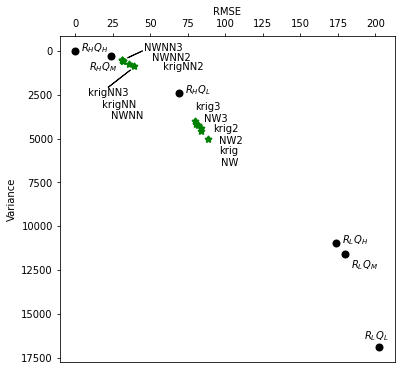

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('RMSE')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.scatter(ap.loc[:,"RMSE"],ap.loc[:,"variance"], linewidth=2.0,c="black")

ax.scatter(ap2.loc[:,"RMSE"],ap2.loc[:,"variance"], linewidth=2.0,c="green",marker ="*")

ax.text(ap['RMSE'][0]+4, ap['variance'][0], '$R_HQ_H$')
ax.text(ap['RMSE'][1]-15, ap['variance'][1]+800, '$R_HQ_M$')
ax.text(ap['RMSE'][2]+4, ap['variance'][2], '$R_HQ_L$')
ax.text(ap['RMSE'][3]+4, ap['variance'][3], '$R_LQ_H$')
ax.text(ap['RMSE'][4]+4, ap['variance'][4]+800, '$R_LQ_M$')
ax.text(ap['RMSE'][5]-10, ap['variance'][5]-500, '$R_LQ_L$')

ax.text(ap2['RMSE'][0]+12, ap2['variance'][0]+1300, 'krig')
ax.text(ap2['RMSE'][1]+9, ap2['variance'][1]+1500, 'NW')
ax.text(ap2['RMSE'][2]+10, ap2['variance'][2]+400, 'krig2')
ax.text(ap2['RMSE'][3]+12, ap2['variance'][3]+900, 'NW2')
ax.text(ap2['RMSE'][4], ap2['variance'][4]-600, 'krig3')
ax.text(ap2['RMSE'][5]+5, ap2['variance'][5]-150, 'NW3')

ax.text(ap2['RMSE'][6]-20, ap2['variance'][6]+2500, ' krigNN')
ax.text(ap2['RMSE'][7]-15, ap2['variance'][7]+3000, 'NWNN')
ax.text(ap2['RMSE'][8]+25, ap2['variance'][8]+500, ' krigNN2')
ax.text(ap2['RMSE'][9]+20, ap2['variance'][9], 'NWNN2')
ax.text(ap2['RMSE'][10]-25, ap2['variance'][10]+2000, ' krigNN3')
ax.text(ap2['RMSE'][11]+15, ap2['variance'][11]-500, 'NWNN3')

ax.arrow(ap2['RMSE'][11]+14, ap2['variance'][11]-500,-10, +400)
ax.arrow(ap2['RMSE'][10]-10, ap2['variance'][10]+1500,+15, -1000)
        
ax.set(ylabel='Variance')

fig_filename = os.path.join(parent_dir,'fig','ap_topo_plot.png')
plt.savefig(fig_filename, dpi = 300)

## Producing dataset of 4 sources of sensors  

In [24]:
def produce_4sources(all_xyv,key,ap,name,parent_dir):
    
    all_xyv.loc[:,"ref"] = all_xyv.loc[:,"sensor_hq"]
    all_xyv.loc[:,"rmse_ref"] = ap.loc['sensor_hq','RMSE']
    all_xyv.loc[:,"variance_ref"] = ap.loc['sensor_hq','variance']
    
    melted = all_xyv.melt(id_vars=["x","y","ref","rmse_ref","variance_ref"],value_vars=key,ignore_index=True)
    melted.loc[melted["variable"]=="sensor_hq", "rmse"] = ap.loc['sensor_hq','RMSE']
    melted.loc[melted["variable"]=="sensor_lq", "rmse"] = ap.loc['sensor_lq','RMSE']
    melted.loc[melted["variable"]=="pixel_hq", "rmse"] = ap.loc['pixel_hq','RMSE']
    melted.loc[melted["variable"]=="pixel_lq", "rmse"] = ap.loc['pixel_lq','RMSE']
    
    melted.loc[melted["variable"]=="sensor_hq", "variance"] = ap.loc['sensor_hq','variance']
    melted.loc[melted["variable"]=="sensor_lq", "variance"] = ap.loc['sensor_lq','variance']
    melted.loc[melted["variable"]=="pixel_hq", "variance"] = ap.loc['pixel_hq','variance']
    melted.loc[melted["variable"]=="pixel_lq", "variance"] = ap.loc['pixel_lq','variance']
    
    newpath = os.path.join(parent_dir,'session',name+'_4s','tab')
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    f = os.path.join(newpath,'dataset.csv')
    melted.to_csv(f,index=False)

In [25]:
def produce_set_4sources(nb_sampling,key,ap,parent_dir):
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_X_train','tab'),'dataset.csv'))
    produce_4sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_X_train',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_Y_train','tab'),'dataset.csv'))
    produce_4sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_Y_train',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_X_valid','tab'),'dataset.csv'))
    produce_4sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_X_valid',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_Y_valid','tab'),'dataset.csv'))
    produce_4sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_Y_valid',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_X_eval','tab'),'dataset.csv'))
    produce_4sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_X_eval',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_Y_eval','tab'),'dataset.csv'))
    produce_4sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_Y_eval',parent_dir)
    

In [26]:
key = ['sensor_hq','sensor_lq','pixel_hq','pixel_lq']
produce_set_4sources(1000,key,ap,parent_dir)

In [27]:
all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_all_'+str(6400),'tab'),'dataset.csv'))
produce_4sources(all_xyv,key,ap,'synth_all_'+str(6400),parent_dir)

## Producing dataset of 6 sources of sensors  

In [28]:
def produce_6sources(all_xyv,key,ap,name,parent_dir):
    
    all_xyv.loc[:,"ref"] = all_xyv.loc[:,"sensor_hq"]
    all_xyv.loc[:,"rmse_ref"] = ap.loc['sensor_hq','RMSE']
    all_xyv.loc[:,"variance_ref"] = ap.loc['sensor_hq','variance']
    
    melted = all_xyv.melt(id_vars=["x","y","ref","rmse_ref","variance_ref"],value_vars=key,ignore_index=True)
    melted.loc[melted["variable"]=="sensor_hq", "rmse"] = ap.loc['sensor_hq','RMSE']
    melted.loc[melted["variable"]=="sensor_mq", "rmse"] = ap.loc['sensor_mq','RMSE']
    melted.loc[melted["variable"]=="sensor_lq", "rmse"] = ap.loc['sensor_lq','RMSE']
    melted.loc[melted["variable"]=="pixel_hq", "rmse"] = ap.loc['pixel_hq','RMSE']
    melted.loc[melted["variable"]=="pixel_mq", "rmse"] = ap.loc['pixel_mq','RMSE']
    melted.loc[melted["variable"]=="pixel_lq", "rmse"] = ap.loc['pixel_lq','RMSE']
    
    melted.loc[melted["variable"]=="sensor_hq", "variance"] = ap.loc['sensor_hq','variance']
    melted.loc[melted["variable"]=="sensor_mq", "variance"] = ap.loc['sensor_mq','variance']
    melted.loc[melted["variable"]=="sensor_lq", "variance"] = ap.loc['sensor_lq','variance']
    melted.loc[melted["variable"]=="pixel_hq", "variance"] = ap.loc['pixel_hq','variance']
    melted.loc[melted["variable"]=="pixel_mq", "variance"] = ap.loc['pixel_mq','variance']
    melted.loc[melted["variable"]=="pixel_lq", "variance"] = ap.loc['pixel_lq','variance']
    
    newpath = os.path.join(parent_dir,'session',name+'_6s','tab')
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    f = os.path.join(newpath,'dataset.csv')
    melted.to_csv(f,index=False)

In [29]:
def produce_set_6sources(nb_sampling,key,ap,parent_dir):
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_X_train','tab'),'dataset.csv'))
    produce_6sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_X_train',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_Y_train','tab'),'dataset.csv'))
    produce_6sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_Y_train',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_X_valid','tab'),'dataset.csv'))
    produce_6sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_X_valid',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_Y_valid','tab'),'dataset.csv'))
    produce_6sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_Y_valid',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_X_eval','tab'),'dataset.csv'))
    produce_6sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_X_eval',parent_dir)
    
    all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_'+str(nb_sampling)+'_Y_eval','tab'),'dataset.csv'))
    produce_6sources(all_xyv,key,ap,'synth_'+str(nb_sampling)+'_Y_eval',parent_dir)
    

In [30]:
key = ['sensor_hq','sensor_mq','sensor_lq','pixel_hq','pixel_mq','pixel_lq']
produce_set_6sources(1000,key,ap,parent_dir)

In [31]:
all_xyv = pd.read_csv(os.path.join(os.path.join(parent_dir,'session','synth_all_'+str(6400),'tab'),'dataset.csv'))
produce_6sources(all_xyv,key,ap,'synth_all_'+str(6400),parent_dir)